## Overview

The goal of this notebook is to gather data from the National Transit Database (NTD) and parse it into something usable for our transit carbon calculations. There are two datasets we need to import and parse, one being [NTD Annual Data - Fuel and Energy](https://data.transportation.gov/Public-Transit/2022-NTD-Annual-Data-Fuel-and-Energy/8ehq-7his/data) set, and the other being [NTD Service](https://www.transit.dot.gov/ntd/data-product/2022-service).

#### To Maintain

To update the data each year, update `urls` below with the most recent download links.

In [2]:
ntd_urls = {
  2022: {
    # https://www.transit.dot.gov/ntd/data-product/2022-fuel-and-energy
    "fuel_energy_csv": "https://data.transportation.gov/api/views/8ehq-7his/rows.csv?date=20231027&accessType=DOWNLOAD&bom=true&format=true",
    # https://www.transit.dot.gov/ntd/data-product/2022-service
    "service_csv": "https://data.transportation.gov/api/views/4fir-qbim/rows.csv?date=20231102&accessType=DOWNLOAD&bom=true&format=true",
    # https://www.transit.dot.gov/ntd/data-product/2022-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-07/2022%20Agency%20Information_1-3_0.xlsx",
  },
  2021: {
    # https://www.transit.dot.gov/ntd/data-product/2021-fuel-and-energy
    "fuel_energy_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2023-12/2021%20Fuel%20and%20Energy_1-1_0.xlsx",
    # https://www.transit.dot.gov/ntd/data-product/2021-service
    "service_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2022-10/2021%20Service_static.xlsx",
    # https://www.transit.dot.gov/ntd/data-product/2021-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2022-10/2021%20Agency%20Information.xlsx",
  },
  2020: {
    # https://www.transit.dot.gov/ntd/data-product/2020-fuel-and-energy
    "fuel_energy_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2023-12/2020-Fuel%20and%20Energy_1-1_1.xlsx",
    # https://www.transit.dot.gov/ntd/data-product/2020-service
    "service_zip": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2020-Service.zip",
    # https://www.transit.dot.gov/ntd/data-product/2020-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-11/2020%20Agency%20Information.xlsx",
  },
  2019: {
    # https://www.transit.dot.gov/ntd/data-product/2019-fuel-and-energy
    "fuel_energy_zip": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Fuel%20and%20Energy.zip",
    # https://www.transit.dot.gov/ntd/data-product/2019-service
    "service_zip": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Service.zip",
    # https://www.transit.dot.gov/ntd/data-product/2019-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-05/2019%20Agency%20Info.xlsx",
  },
  2018: {
    # https://www.transit.dot.gov/ntd/data-product/2018-fuel-and-energy
    "fuel_energy_xlsm": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Fuel%20and%20Energy_3.xlsm",
    # https://www.transit.dot.gov/ntd/data-product/2018-service
    "service_xlsm": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Service_4.xlsm",
    # https://www.transit.dot.gov/ntd/data-product/2018-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2018%20Agency%20Info_1.xlsx",
  }
}

# XLSX detailing urbanized areas; establishes relationship UACE Codes and UZA codes (which were used pre-2022)
census_changes_xlsx = "https://www.transit.dot.gov/sites/fta.dot.gov/files/2023-10/UZA_CHANGES_1990-2020_2_5.xlsx"

In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import json
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
import re

In [4]:
# create UZA to UACE mapping using the census_changes_xlsx

census_changes_df = pd.read_excel(census_changes_xlsx)
census_changes_df = census_changes_df[["2010 NTD UZA Code (Deprecated)", "2020 UACE"]].dropna().astype(int)
# pad to 5 digits
census_changes_df['2020 UACE'] = census_changes_df['2020 UACE'].apply(lambda x: str(x).zfill(5))
uza_to_uace = census_changes_df.set_index("2010 NTD UZA Code (Deprecated)")["2020 UACE"].to_dict()
print("uza_to_uace: " + json.dumps(uza_to_uace, indent=2))

uza_to_uace: {
  "1": "63217",
  "2": "51445",
  "3": "16264",
  "4": "56602",
  "7": "40429",
  "6": "22042",
  "5": "69076",
  "8": "92242",
  "9": "03817",
  "10": "09271",
  "12": "69184",
  "11": "23824",
  "14": "80389",
  "13": "78904",
  "15": "78661",
  "16": "57628",
  "17": "86599",
  "18": "23527",
  "22": "75340",
  "19": "04843",
  "23": "47995",
  "20": "77770",
  "24": "71317",
  "26": "78580",
  "28": "77068",
  "32": "65863",
  "21": "79093",
  "29": "79039",
  "37": "04384",
  "27": "69697",
  "25": "17668",
  "33": "41212",
  "30": "16885",
  "31": "43912",
  "36": "19234",
  "34": "90892",
  "38": "15670",
  "35": "57466",
  "39": "72505",
  "40": "42346",
  "42": "78499",
  "44": "61273",
  "50": "73261",
  "45": "74746",
  "41": "56116",
  "51": "65080",
  "47": "37243",
  "43": "51755",
  "49": "62677",
  "46": "11350",
  "48": "10162",
  "52": "88732",
  "53": "27253",
  "54": "39889",
  "58": "65269",
  "57": "52390",
  "64": "09536",
  "55": "07786",
  "56": 

In [5]:
output = {}

def load_dataframe(urls, db_name, sheet_name=0):
    '''
    Return a dataframe for the given urls, database name and sheet name.
    '''
    if db_name + "_csv" in urls:
        return pd.read_csv(urls[db_name + "_csv"])
    elif db_name + "_xlsx" in urls:
        return pd.read_excel(urls[db_name + "_xlsx"], sheet_name=sheet_name)
    elif db_name + "_xlsm" in urls:
        with urlopen(urls[db_name + "_xlsm"]) as xlsm_file:
            return pd.read_excel(BytesIO(xlsm_file.read()), sheet_name=sheet_name)
    elif db_name + "_zip" in urls:
        with urlopen(urls[db_name + "_zip"]) as zip_file:
            with ZipFile(BytesIO(zip_file.read())) as zip_ref:
                with zip_ref.open(zip_ref.namelist()[0]) as xlsm_file:
                    return pd.read_excel(xlsm_file, sheet_name=sheet_name)
                

def agg_by_ntd_id_and_mode(df):
    # remove commas, convert to numeric, and sort
    df = df.replace({',': ''}, regex=True)
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.sort_values(by=['NTD ID', 'Mode'])
    # sum rows with the same NTD ID and Mode
    df = df.groupby(['NTD ID', 'Mode'], as_index=False).sum()
    return df


def make_fuel_energy_df(urls):
    df = load_dataframe(urls, 'fuel_energy', 'Fuel and Energy')
    cols = {
        'NTD ID': 'NTD ID',
        'Mode': 'Mode',
        # usage by fuel type
        'Diesel (gal)': 'Diesel (gal)',
        'Gasoline (gal)': 'Gasoline (gal)',
        'Liquefied Petroleum Gas (gal equivalent)': 'Liquefied Petroleum Gas (gal equivalent)',
        'Compressed Natural Gas (gal equivalent)': 'Compressed Natural Gas (gal equivalent)',
        'Bio-Diesel (gal)': 'Bio-Diesel (gal)',
        'Hydrogen (kg)': 'Hydrogen (kg)',
        'Other Fuel (gal/gal equivalent)': 'Other Fuel (gal/gal equivalent)',
        'Electric Propulsion (kwh)': 'Electric Propulsion (kWh)', # requires rename (kwh -> kWh)
        'Electric Battery (kwh)': 'Electric Battery (kWh)', # requires rename (kwh -> kWh)
        # miles by fuel type
        # require renames as older years did not include (miles) in the column name
        'Diesel': 'Diesel (miles)',
        'Gasoline': 'Gasoline (miles)',
        'Liquefied Petroleum Gas': 'Liquefied Petroleum Gas (miles)',
        'Compressed Natural Gas': 'Compressed Natural Gas (miles)',
        # 'Bio-Diesel': 'Bio-Diesel (miles)',
        'Hydrogen': 'Hydrogen (miles)',
        'Other Fuel': 'Other Fuel (miles)',
        'Electric Propulsion': 'Electric Propulsion (miles)',
        'Electric Battery': 'Electric Battery (miles)',
        'Diesel (mpg)': 'Diesel (mpg)',
        'Gasoline (mpg)': 'Gasoline (mpg)',
        'Liquefied Petroleum Gas (mpg)': 'Liquefied Petroleum Gas (mpg)',
        'Compressed Natural Gas (mpg)': 'Compressed Natural Gas (mpg)',
        'Other Fuel (mpg)': 'Other Fuel (mpg)',
        'Electric Propulsion (mi/kwh)': 'Electric Propulsion (mi/kWh)',
        'Electric Battery (mi/kwh)': 'Electric Battery (mi/kWh)',
        'Hydrogen (mpkg)': 'Hydrogen (mpkg)'
    }
    df = df.rename(columns=cols)

    # "Hydrogen" fuel type did not exist in older years
    # if these cols are missing, add them with all 0 values
    if 'Hydrogen (miles)' not in df.columns:
        df['Hydrogen (miles)'] = 0
    if 'Hydrogen (kg)' not in df.columns:
        df['Hydrogen (kg)'] = 0
    if 'Hydrogen (mpkg)' not in df.columns:
        df['Hydrogen (mpkg)'] = 0

    if 'UACE Code' not in df.columns:
        agency_info_df = load_dataframe(urls, 'agency_info')[['NTD ID', 'Primary UZA']]
        agency_info_df['UACE Code'] = agency_info_df['Primary UZA'].map(uza_to_uace)
        ntd_to_uace = agency_info_df.set_index("NTD ID")["UACE Code"].to_dict()
    else:
        ntd_to_uace = df.set_index("NTD ID")["UACE Code"].apply(lambda x: str(x).zfill(5)).to_dict()

    df = df[list(cols.values())]
    df = agg_by_ntd_id_and_mode(df)

    # add UACE Code and drop rows where it is missing
    df['UACE Code'] = df['NTD ID'].map(ntd_to_uace)
    df = df.dropna(subset=['UACE Code'])

    # add a column for total miles across all fuel types
    # and remove any rows where this is 0
    df['All Fuels (miles)'] = df['Diesel (miles)'] \
                            + df['Gasoline (miles)'] \
                            + df['Liquefied Petroleum Gas (miles)'] \
                            + df['Compressed Natural Gas (miles)'] \
                            + df['Hydrogen (miles)'] \
                            + df['Other Fuel (miles)'] \
                            + df['Electric Propulsion (miles)'] \
                            + df['Electric Battery (miles)']
    df = df[df['All Fuels (miles)'] != 0]

    # Drop mpg / mi/kWh outliers
    # avg_efficiency = {
    #     "Diesel": 3.4,
    #     "Gasoline": 3.4,
    #     "Liquefied Petroleum Gas": 2.35,
    #     "Compressed Natural Gas": 2.2,
    #     "Electric Propulsion": 2.5,
    #     "Electric Battery": 2.5,
    #     "Hydrogen": 7

    # }

    # factor = 2.5
    # low = 1 - 0.5
    # high = 1 + 2.5

    # fuel_efficiency_bounds = {
    #     "Diesel (mpg)": {"low": avg_efficiency["Diesel"] * low, "high": avg_efficiency["Diesel"] * high},
    #     "Gasoline (mpg)": {"low": avg_efficiency["Gasoline"] * low, "high": avg_efficiency["Gasoline"] * high},
    #     "Liquefied Petroleum Gas (mpg)": {"low": avg_efficiency["Liquefied Petroleum Gas"] * low, "high": avg_efficiency["Liquefied Petroleum Gas"] * high},
    #     "Compressed Natural Gas (mpg)": {"low": avg_efficiency["Compressed Natural Gas"] * low, "high": avg_efficiency["Compressed Natural Gas"] * high},
    #     "Electric Propulsion (mi/kWh)": {"low": avg_efficiency["Electric Propulsion"] * low, "high": avg_efficiency["Electric Propulsion"] * high},
    #     "Electric Battery (mi/kWh)": {"low": avg_efficiency["Electric Battery"] * low, "high": avg_efficiency["Electric Battery"] * high},
    #     "Hydrogen (mpkg)": {"low": avg_efficiency["Hydrogen"] * low, "high": avg_efficiency["Hydrogen"] * high},
    # }


    fuel_efficiency = [
        "Diesel (mpg)",
        "Gasoline (mpg)",
        "Liquefied Petroleum Gas (mpg)",
        "Compressed Natural Gas (mpg)",
        "Electric Propulsion (mi/kWh)",
        "Electric Battery (mi/kWh)",
        "Hydrogen (mpkg)"
    ]

    # recompute all mpg
    fields = {
        "Diesel": ("(gal)", "(mpg)"),
        "Gasoline": ("(gal)", "(mpg)"),
        "Liquefied Petroleum Gas": ("(gal equivalent)", "(mpg)"),
        "Compressed Natural Gas": ("(gal equivalent)", "(mpg)"),
        "Electric Propulsion": ("(kWh)", "(mi/kWh)"),
        "Electric Battery": ("(kWh)", "(mi/kWh)"),
        "Hydrogen": ("(kg)", "(mpkg)")
    }

    def safe_divide(miles, units):
        if units == 0:
            return 0
        else:
            return miles / units

    for field, (unit, effic) in fields.items():
        column_unit = field + " " + unit
        column_effic = field + " " + effic
        column_miles = field + " (miles)"
        df[column_effic] = df.apply(lambda row: safe_divide(row[column_miles], row[column_unit]), axis=1)


    print("BEFORE: " + str(len(df)))
    
    # for fuel in fuel_efficiency:            
    #     # Calculate the 10th and 90th percentiles
    #     lower_bound = df[fuel].quantile(0.10)
    #     upper_bound = df[fuel].quantile(0.90)
    #     # Filter out the outliers
    #     df = df[(df[fuel] >= lower_bound) & (df[fuel] <= upper_bound) | (df[fuel] == 0)]

    # for fuel in fuel_efficiency:     
    #     # Calculate the mean and standard deviation
    #     mean = df[fuel].mean()
    #     std_dev = df[fuel].std()
    #     # Define the bounds
    #     lower_bound = mean - 2 * std_dev
    #     upper_bound = mean + 2 * std_dev
    #     # Filter out the outliers
    #     df = df[(df[fuel] >= lower_bound) & (df[fuel] <= upper_bound) | (df[fuel] == 0)]


    print("AFTER: " + str(len(df)))

    return df

def make_service_df(urls):
    df = load_dataframe(urls, 'service', 'Annual Service Data By Mode')
    cols = {
        'NTD ID': 'NTD ID',
        'Mode': 'Mode',
        'Passenger Miles': 'Passenger Miles Traveled', # requires rename
        'Unlinked Passenger Trips (UPT)': 'Unlinked Passenger Trips', # requires rename
        'Actual Vehicle/Passenger Car Miles': 'Vehicle Miles', # requires rename
        'Train Miles': 'Train Miles'
    }
    df = df.rename(columns=cols)
    df = df[list(cols.values())]

    df = agg_by_ntd_id_and_mode(df)

    # remove rows that have "Passenger Miles Traveled" = 0
    df = df[df['Passenger Miles Traveled'] != 0]
    return df


for year, urls in ntd_urls.items():
    fuel_energy_df = make_fuel_energy_df(urls)
    service_df = make_service_df(urls)
    df = fuel_energy_df.merge(service_df, on=['NTD ID', 'Mode'])
    df = df.convert_dtypes()
    output[year] = df.to_dict(orient='records')

BEFORE: 1097
AFTER: 1097
BEFORE: 1085
AFTER: 1085
BEFORE: 1046
AFTER: 1046
BEFORE: 1018
AFTER: 1018
BEFORE: 1080
AFTER: 1080


Dump output to a file called `ntd_data_by_year.py`

In [6]:
with open('../src/emcommon/metrics/footprint/louis_ntd_data_by_year.py', 'w') as f:
  f.write(f"ntd_data = {json.dumps(output, indent=2)}\n")

In [7]:
import copy

DIESEL_GGE = 1.136 # from energy.gov
KWH_PER_GALLON_GASOLINE = 33.7 # from the EPA, used as the basis for MPGe
KWH_PER_GALLON_DIESEL = KWH_PER_GALLON_GASOLINE * 1.14
# GGE constants found from https://epact.energy.gov/fuel-conversion-factors
KWH_PER_GALLON_BIODIESEL = KWH_PER_GALLON_GASOLINE * 1.05 
KWH_PER_GALLON_LPG = KWH_PER_GALLON_GASOLINE * .74
KWH_PER_GALLON_CNG = KWH_PER_GALLON_GASOLINE * .26
KWH_PER_KG_HYDROGEN = KWH_PER_GALLON_GASOLINE * 1.00

ntd_data = copy.deepcopy(output)


fuel_types = {
    "Diesel (mpg)": KWH_PER_GALLON_DIESEL,
    "Gasoline (mpg)": KWH_PER_GALLON_GASOLINE,
    "Liquefied Petroleum Gas (mpg)": KWH_PER_GALLON_LPG,
    "Compressed Natural Gas (mpg)": KWH_PER_GALLON_CNG,
    "Electric Propulsion (mi/kWh)": 1,
    "Electric Battery (mi/kWh)": 1,
    "Hydrogen (mpkg)": KWH_PER_KG_HYDROGEN,
}

def calculate(trip, modes):
    year = trip["year"]
    code = trip["code"]

    aggregate_agencies = []
    total_passenger_trips = 0
    
    '''
    1. Sum up total passenger miles to calculate weight by agency later
    2. Calculate efficiency for each fuel
    3. Calculate weight of each fuel type
    4. Adjust miles using the weights to match mileage in service data
    5. Saved that data in aggregate_agencies
    '''
    for agency in ntd_data[year]:
        if agency["UACE Code"] == code and agency["Mode"] in modes:
            # Add up all the service data miles so we can calculate weight by agency later
            total_passenger_trips += agency["Unlinked Passenger Trips"]
            # Calculate the efficiency of each fuel
            for fuel_type in fuel_types: 
                wh_per_pkm = calculate_wh_per_pkm(agency, fuel_type)
                field_name = fuel_type.split(" (").pop(0) + " (wh/km)"
                agency[field_name] = wh_per_pkm
            # Calculate the weight of each fuel type and then add it in to the data
            fuel_weights = calculate_fuel_weights(agency)
            agency["fuel_weights"] = fuel_weights
            # Adjust miles using weights to match the mileage in the service data
            for fuel in fuel_weights:
                fuel_miles = fuel + " (miles)"
                agency[fuel_miles] = fuel_weights[fuel] * (agency["Train Miles"] or agency["Vehicle Miles"])
                # agency[fuel_miles] = fuel_weights[fuel] * (agency["Train Miles"] + agency["Vehicle Miles"])
            # Save all the agencies in one place
            aggregate_agencies.append(agency)
    
    fuel_averages = {
        "Diesel": [],
        "Gasoline": [],
        "Liquefied Petroleum Gas": [],
        "Compressed Natural Gas": [],
        "Electric Propulsion": [],
        "Electric Battery": [],
        "Hydrogen": []
    }

    '''
    6. Calculate weight by agency (% of passenger miles)
    7. Adjust the fuel weights using the weight by agency (fuel_weight * weight)
    8. Start aggregating data to use for the weighted average calculations
    '''
    for agency in aggregate_agencies:
        # Calculate weight by agency
        weight = agency["Unlinked Passenger Trips"] / total_passenger_trips
        agency["weight"] = weight
        # Adjust fuel weights
        for fuel_weight in agency["fuel_weights"]:
            agency["fuel_weights"][fuel_weight] *= weight
        # Add in data to calculate the weighted averages
        for fuel in fuel_averages:
            efficiency = agency[fuel + " (wh/km)"]
            weighted = agency["fuel_weights"][fuel]
            weighted_efficiency = efficiency * weighted
            fuel_averages[fuel].append((weighted_efficiency, weighted))

    '''
    9. Calculate weighted averages
    '''
    result = {}
    overall = 0
    for fuel in fuel_averages:
        combined_weighted_efficiency = 0
        combined_weighted = 0
        weighted_average = 0
        for (weighted_efficiency, weighted) in fuel_averages[fuel]:
            combined_weighted_efficiency += weighted_efficiency
            combined_weighted += weighted
        if combined_weighted != 0:
            weighted_average = combined_weighted_efficiency / combined_weighted
        result[fuel] = {
            "wh_per_pkm": weighted_average,
            "weight": combined_weighted
        }
        overall += (weighted_average * combined_weighted)
    result['overall'] = {
        'wh_per_km': overall,
        'weight': 1.0
    }
    
    print(json.dumps(result, indent=4))

def calculate_wh_per_pkm(agency, fuel_type):
    fuel = agency[fuel_type]
    # Convert to km
    km_per_gallon = fuel * 1.60934
    # Convert to wh
    wh_per_km = 0
    if km_per_gallon != 0:
        wh_per_km = (fuel_types[fuel_type] * 1000) / km_per_gallon
    # load_factor = agency["Passenger Miles Traveled"] / (agency["Vehicle Miles"] + agency["Train Miles"]) 
    load_factor = agency["Passenger Miles Traveled"] / (agency["Train Miles"] or agency["Vehicle Miles"]) 
    wh_per_pkm = wh_per_km / load_factor
    return wh_per_pkm

def calculate_fuel_weights(agency):
    fuels = ["Diesel (miles)","Gasoline (miles)","Liquefied Petroleum Gas (miles)","Compressed Natural Gas (miles)","Hydrogen (miles)","Electric Propulsion (miles)","Electric Battery (miles)"]
    fuel_weights = {}
    for fuel in fuels:
        pct = 0
        if agency["All Fuels (miles)"] != 0:
            pct = agency[fuel] / agency["All Fuels (miles)"]
        field_name = fuel.split(" (").pop(0)
        fuel_weights[field_name] = pct
    return fuel_weights
    


trip = {
    "year": 2022,
    "code": "16264"
}
modes = ["LR", "HR", "YR", "CR"]
calculate(trip, modes)


{
    "Diesel": {
        "wh_per_pkm": 1039.967804758374,
        "weight": 0.10039037930895427
    },
    "Gasoline": {
        "wh_per_pkm": 0,
        "weight": 0.0
    },
    "Liquefied Petroleum Gas": {
        "wh_per_pkm": 0,
        "weight": 0.0
    },
    "Compressed Natural Gas": {
        "wh_per_pkm": 0,
        "weight": 0.0
    },
    "Electric Propulsion": {
        "wh_per_pkm": 60.729704362421494,
        "weight": 0.8996096206910458
    },
    "Electric Battery": {
        "wh_per_pkm": 0,
        "weight": 0.0
    },
    "Hydrogen": {
        "wh_per_pkm": 0,
        "weight": 0.0
    },
    "overall": {
        "wh_per_km": 159.035788694951,
        "weight": 1.0
    }
}


year: 2018
NTD ID                                               Int64
Mode                                        string[python]
Diesel (gal)                                         Int64
Gasoline (gal)                                       Int64
Liquefied Petroleum Gas (gal equivalent)             Int64
Compressed Natural Gas (gal equivalent)              Int64
Bio-Diesel (gal)                                     Int64
Hydrogen (kg)                                        Int64
Other Fuel (gal/gal equivalent)                      Int64
Electric Propulsion (kWh)                            Int64
Electric Battery (kWh)                               Int64
Diesel (miles)                                       Int64
Gasoline (miles)                                     Int64
Liquefied Petroleum Gas (miles)                      Int64
Compressed Natural Gas (miles)                       Int64
Hydrogen (miles)                                     Int64
Other Fuel (miles)                           

,NTD ID,Mode,Diesel (gal),Gasoline (gal),Liquefied Petroleum Gas (gal equivalent),Compressed Natural Gas (gal equivalent),Bio-Diesel (gal),Hydrogen (kg),Other Fuel (gal/gal equivalent),Electric Propulsion (kWh),...,Other Fuel (mpg),Electric Propulsion (mi/kWh),Electric Battery (mi/kWh),Hydrogen (mpkg),UACE Code,All Fuels (miles),Passenger Miles Traveled,Unlinked Passenger Trips,Vehicle Miles,Train Miles
0,1,DR,394253,477232,345727,0,0,0,0,0,...,0,0.0,0.0,0,80389,10039529,8840480,883312,9876720,0
1,1,FB,23496,0,0,0,207457,0,0,0,...,0,0.0,0.0,0,80389,53398,3323914,664365,49706,0
2,1,MB,10123152,117340,0,0,0,0,0,0,...,0,0.0,0.38614,0,80389,44322577,505978822,104261625,44809136,0
3,1,SR,0,0,0,0,0,0,0,2449153,...,0,0.086385,0.0,0,80389,211570,1856308,1685668,211570,211570
4,1,TB,0,0,0,0,0,0,0,20181683,...,0,0.162108,0.0,0,80389,3271603,34367474,17950742,3271438,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,99422,VP,0,38574,0,0,0,0,0,0,...,0,0.0,0.0,0,85087,766924,3839997,84645,699350,0
1075,99423,DR,0,24085,0,0,0,0,0,0,...,0,0.0,0.0,0,51445,163185,253741,45144,183626,0
1076,99423,MB,0,0,0,301187,0,0,0,0,...,0,0.0,0.0,0,51445,793336,3300627,1504383,761251,0
1077,99424,DR,0,31701,0,0,0,0,0,0,...,0,0.0,0.0,0,51445,268560,302794,80378,263560,0


Outliers where All Fuels (miles) / Vehicle Miles > 5: 2


,NTD ID,Mode,All Fuels (miles) / Vehicle Miles
360,40008,CB,6.952359
698,50517,MB,32.61928


Outliers where All Fuels (miles) / Vehicle Miles < 0.2: 14


,NTD ID,Mode,All Fuels (miles) / Vehicle Miles
62,40,CR,0.161075
281,30034,CB,0.057569
301,30070,VP,0.11854
305,30073,CR,0.157444
314,30081,DR,0.006517
450,40063,MB,0.131706
599,50040,CB,0.186342
667,50157,CB,0.130749
689,50199,MB,0.186375
751,60048,CB,0.048961


Rows where All Fuels (miles) is within 10% of Vehicle Miles: 697


,NTD ID,Mode,Diesel (gal),Gasoline (gal),Liquefied Petroleum Gas (gal equivalent),Compressed Natural Gas (gal equivalent),Bio-Diesel (gal),Hydrogen (kg),Other Fuel (gal/gal equivalent),Electric Propulsion (kWh),...,Electric Propulsion (mi/kWh),Electric Battery (mi/kWh),Hydrogen (mpkg),UACE Code,All Fuels (miles),Passenger Miles Traveled,Unlinked Passenger Trips,Vehicle Miles,Train Miles,All Fuels (miles) / Vehicle Miles
0,1,DR,394253,477232,345727,0,0,0,0,0,...,0.0,0.0,0,80389,10039529,8840480,883312,9876720,0,1.016484
1,1,FB,23496,0,0,0,207457,0,0,0,...,0.0,0.0,0,80389,53398,3323914,664365,49706,0,1.074277
2,1,MB,10123152,117340,0,0,0,0,0,0,...,0.0,0.38614,0,80389,44322577,505978822,104261625,44809136,0,0.989142
3,1,SR,0,0,0,0,0,0,0,2449153,...,0.086385,0.0,0,80389,211570,1856308,1685668,211570,211570,1.0
4,1,TB,0,0,0,0,0,0,0,20181683,...,0.162108,0.0,0,80389,3271603,34367474,17950742,3271438,0,1.00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,90299,CR,272298,0,0,0,0,0,0,0,...,0.0,0.0,0,79498,835370,16174174,636029,771692,386657,1.082517
1074,99422,VP,0,38574,0,0,0,0,0,0,...,0.0,0.0,0,85087,766924,3839997,84645,699350,0,1.096624
1076,99423,MB,0,0,0,301187,0,0,0,0,...,0.0,0.0,0,51445,793336,3300627,1504383,761251,0,1.042148
1077,99424,DR,0,31701,0,0,0,0,0,0,...,0.0,0.0,0,51445,268560,302794,80378,263560,0,1.018971


Rows where All Fuels (miles) is within 5% of Vehicle Miles: 537


,NTD ID,Mode,Diesel (gal),Gasoline (gal),Liquefied Petroleum Gas (gal equivalent),Compressed Natural Gas (gal equivalent),Bio-Diesel (gal),Hydrogen (kg),Other Fuel (gal/gal equivalent),Electric Propulsion (kWh),...,Electric Propulsion (mi/kWh),Electric Battery (mi/kWh),Hydrogen (mpkg),UACE Code,All Fuels (miles),Passenger Miles Traveled,Unlinked Passenger Trips,Vehicle Miles,Train Miles,All Fuels (miles) / Vehicle Miles
0,1,DR,394253,477232,345727,0,0,0,0,0,...,0.0,0.0,0,80389,10039529,8840480,883312,9876720,0,1.016484
2,1,MB,10123152,117340,0,0,0,0,0,0,...,0.0,0.38614,0,80389,44322577,505978822,104261625,44809136,0,0.989142
3,1,SR,0,0,0,0,0,0,0,2449153,...,0.086385,0.0,0,80389,211570,1856308,1685668,211570,211570,1.0
4,1,TB,0,0,0,0,0,0,0,20181683,...,0.162108,0.0,0,80389,3271603,34367474,17950742,3271438,0,1.00005
5,1,VP,0,899358,0,0,0,0,0,0,...,0.0,0.0,0,80389,15131749,65559773,3464738,15043713,0,1.005852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,90234,MB,380991,142048,0,0,0,0,0,0,...,0.0,0.0,0,78904,2638975,12281711,3001619,2647043,0,0.996952
1070,90241,MB,283365,18708,0,0,0,0,0,0,...,0.0,0.0,0,43615,1465659,13073252,1729716,1449971,0,1.01082
1072,90244,MB,0,0,0,98192,0,0,11251,0,...,0.0,0.0,0,90946,590885,1268883,288833,578259,0,1.021835
1076,99423,MB,0,0,0,301187,0,0,0,0,...,0.0,0.0,0,51445,793336,3300627,1504383,761251,0,1.042148


Rows where All Fuels (miles) is within 1% of Vehicle Miles: 217


,NTD ID,Mode,Diesel (gal),Gasoline (gal),Liquefied Petroleum Gas (gal equivalent),Compressed Natural Gas (gal equivalent),Bio-Diesel (gal),Hydrogen (kg),Other Fuel (gal/gal equivalent),Electric Propulsion (kWh),...,Electric Propulsion (mi/kWh),Electric Battery (mi/kWh),Hydrogen (mpkg),UACE Code,All Fuels (miles),Passenger Miles Traveled,Unlinked Passenger Trips,Vehicle Miles,Train Miles,All Fuels (miles) / Vehicle Miles
3,1,SR,0,0,0,0,0,0,0,2449153,...,0.086385,0.0,0,80389,211570,1856308,1685668,211570,211570,1.0
4,1,TB,0,0,0,0,0,0,0,20181683,...,0.162108,0.0,0,80389,3271603,34367474,17950742,3271438,0,1.00005
5,1,VP,0,899358,0,0,0,0,0,0,...,0.0,0.0,0,80389,15131749,65559773,3464738,15043713,0,1.005852
13,5,MB,312206,0,0,0,0,0,0,0,...,0.0,0.428727,0,80389,1450432,6849311,1800312,1463519,0,0.991058
22,8,LR,0,0,0,0,0,0,0,55759837,...,0.163577,0.0,0,71317,9121033,210180550,38919828,9046229,4544076,1.008269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,90196,MB,26317,19243,0,361478,0,0,0,0,...,0.0,0.0,0,77068,1594912,4936901,654605,1608832,0,0.991348
1031,90196,VP,0,14563,0,0,0,0,0,0,...,0.0,0.0,0,77068,211609,763653,22520,211609,0,1.0
1053,90223,DR,0,558806,0,0,0,0,0,0,...,0.0,0.0,0,77068,3798506,3537337,365299,3836354,0,0.990134
1056,90226,MB,141388,50291,0,0,0,0,0,0,...,0.0,0.0,0,26405,1035732,7679725,774947,1031158,0,1.004436


Rows where All Fuels (miles) is equal to Vehicle Miles: 45


,NTD ID,Mode,Diesel (gal),Gasoline (gal),Liquefied Petroleum Gas (gal equivalent),Compressed Natural Gas (gal equivalent),Bio-Diesel (gal),Hydrogen (kg),Other Fuel (gal/gal equivalent),Electric Propulsion (kWh),...,Electric Propulsion (mi/kWh),Electric Battery (mi/kWh),Hydrogen (mpkg),UACE Code,All Fuels (miles),Passenger Miles Traveled,Unlinked Passenger Trips,Vehicle Miles,Train Miles,All Fuels (miles) / Vehicle Miles
3,1,SR,0,0,0,0,0,0,0,2449153,...,0.086385,0.0,0,80389,211570,1856308,1685668,211570,211570,1.0
78,58,SR,0,0,0,0,0,0,0,2671183,...,0.162049,0.0,0,71317,432862,10171647,4879658,432862,432862,1.0
79,58,TR,0,0,0,0,0,0,0,375400,...,0.09057,0.0,0,71317,34000,1323526,2068009,34000,0,1.0
183,20078,FB,181481,0,0,0,0,0,0,0,...,0.0,0.0,0,63217,43222,676061,164524,43222,0,1.0
184,20078,MB,53533,0,0,0,0,0,0,0,...,0.0,0.0,0,63217,258717,479073,399621,258717,0,1.0
196,20098,FB,618660,0,0,0,0,0,0,0,...,0.0,0.0,0,63217,181818,3472314,1371821,181818,0,1.0
212,20163,CB,691942,0,0,0,0,0,0,0,...,0.0,0.0,0,63217,3349342,52870209,1624066,3349342,0,1.0
237,30002,DR,0,55714,0,0,0,0,0,0,...,0.0,0.0,0,40753,375349,199128,36205,375349,0,1.0
251,30012,IP,0,0,0,0,0,0,0,91600,...,0.021703,0.0,0,43291,1988,8752,51481,1988,1988,1.0
266,30022,IP,0,0,0,0,0,0,0,226812,...,0.064309,0.0,0,69697,14586,71333,610433,14586,14586,1.0


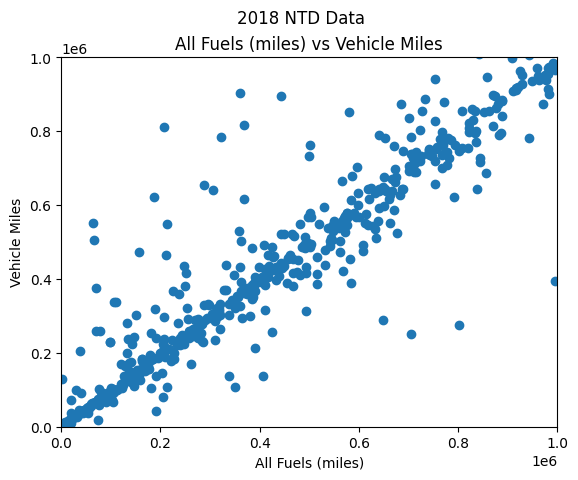

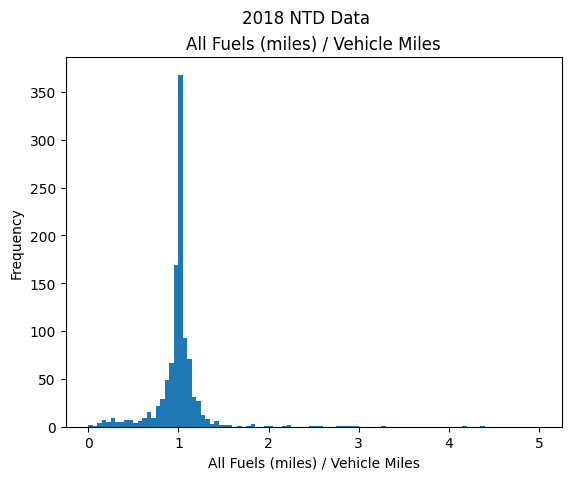

In [8]:
# Plots to investigate discrepancies in miles between "Fuel & Energy" and "Service" data

print('year: ' + str(year))
print(df.dtypes)
display(df)

df['All Fuels (miles) / Vehicle Miles'] = df['All Fuels (miles)'] / df['Vehicle Miles']
max_outliers = df.loc[df['All Fuels (miles) / Vehicle Miles'] > 5][['NTD ID', 'Mode', 'All Fuels (miles) / Vehicle Miles']]
print(f"Outliers where All Fuels (miles) / Vehicle Miles > 5: {len(max_outliers)}")
display(max_outliers)
min_outliers = df.loc[df['All Fuels (miles) / Vehicle Miles'] < 0.2][['NTD ID', 'Mode', 'All Fuels (miles) / Vehicle Miles']]
print(f"Outliers where All Fuels (miles) / Vehicle Miles < 0.2: {len(min_outliers)}")
display(min_outliers)

within_10_percent = df.loc[(df['All Fuels (miles) / Vehicle Miles'] < 1.1) & (df['All Fuels (miles) / Vehicle Miles'] > 0.9)]
print(f"Rows where All Fuels (miles) is within 10% of Vehicle Miles: {len(within_10_percent)}")
display(within_10_percent)

within_5_percent = df.loc[(df['All Fuels (miles) / Vehicle Miles'] < 1.05) & (df['All Fuels (miles) / Vehicle Miles'] > 0.95)]
print(f"Rows where All Fuels (miles) is within 5% of Vehicle Miles: {len(within_5_percent)}")
display(within_5_percent)

within_1_percent = df.loc[(df['All Fuels (miles) / Vehicle Miles'] < 1.01) & (df['All Fuels (miles) / Vehicle Miles'] > 0.99)]
print(f"Rows where All Fuels (miles) is within 1% of Vehicle Miles: {len(within_1_percent)}")
display(within_1_percent)

equal = df.loc[df['All Fuels (miles) / Vehicle Miles'] == 1]
print(f"Rows where All Fuels (miles) is equal to Vehicle Miles: {len(equal)}")
display(equal)

# scatter plot of All Fuels (miles) vs Vehicle Miles
plt.scatter(df['All Fuels (miles)'], df['Vehicle Miles'])
plt.title("All Fuels (miles) vs Vehicle Miles")
plt.suptitle(f"{year} NTD Data")
plt.xlabel("All Fuels (miles)")
plt.ylabel("Vehicle Miles")
plt.xlim(0, 1000000)
plt.ylim(0, 1000000)
plt.show()

# histogram of All Fuels (miles) / Vehicle Miles
plt.hist(df['All Fuels (miles) / Vehicle Miles'], bins=100, range=(0, 5))
plt.title("All Fuels (miles) / Vehicle Miles")
plt.suptitle(f"{year} NTD Data")
plt.xlabel("All Fuels (miles) / Vehicle Miles")
plt.ylabel("Frequency")
plt.show()